### Import packages

In [114]:
from aniposelib.boards import CharucoBoard, Checkerboard
from aniposelib.cameras import Camera, CameraGroup, FisheyeCamera
from aniposelib.utils import load_pose2d_fnames
from cv2 import aruco #fails sometimes, try deinstalling cv2 and reinstalling it via "pip install cv2-contrib-python"

import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import get_cmap

import imageio
import cv2 #not required for this code, but anipose uses cv2 anyways

%matplotlib notebook

## Functions that are required for our suggested anipose workflow

In [145]:
# plotting functions
def connect(ax, points, bps, bp_dict, color):
    ixs = [bp_dict[bp] for bp in bps]
    return ax.plot(points[ixs, 0], points[ixs, 1], points[ixs, 2], color=color)

def connect_all(ax, points, scheme, bodyparts, cmap=None):
    if cmap is None:
        cmap = get_cmap('tab10')
    bp_dict = dict(zip(bodyparts, range(len(bodyparts))))
    lines = []
    for i, bps in enumerate(scheme):
        line = connect(ax, points, bps, bp_dict, color=cmap(i)[:3])
        lines.append(line)
    return lines

def plot_frames_3d(index, p3ds, bodyparts):
    scheme = [["Grün_oben", "Grün_unten", "Schwarz_Unten", "Schwarz_Oben", "Grün_oben"], 
              ["MazeCornerOpenLeft", "MazeCornerOpenRight", "MazeCornerClosedRight", "MazeCornerClosedLeft", "MazeCornerOpenLeft"],
              ["LED1", "LED1_Label", "LED5_Label", "LED5", "LED1"]
             ]

    framenum = index
    p3d = p3ds[framenum]

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(p3d[:,0], p3d[:,1], p3d[:,2], c='black', s=100)
    connect_all(ax, p3d, scheme, bodyparts)
    for i in range(len(bodyparts)):
        ax.text(p3d[i,0], p3d[i,1] + 0.01, p3d[i,2], bodyparts[i], size = 7)
        

def plot_xyz(bodyparts, index, p3ds):

    plt.figure(figsize=(9.4, 6))
    plt.plot(p3ds[:, 0, 0])
    plt.plot(p3ds[:, 0, 1])
    plt.plot(p3ds[:, 0, 2])
    plt.xlabel("Time (frames)")
    plt.ylabel("Coordinate (mm)")
    plt.title("x, y, z coordinates of {}".format(bodyparts[index]))
    plt.show()
        

#function to plot a frame and get the coordinates of marker points
def show_video(filename, index):
    video = imageio.get_reader(filename)
    img = video.get_data(index)
    plt.figure(figsize = (10, 5))
    plt.imshow(img)
    
#calibration
def calibration_func(path, dump = False):      
    vidnames = [[path + vid for vid in os.listdir(path) if vid.endswith(".mp4") & ('bottom' in vid)], [path + vid for vid in os.listdir(path) if vid.endswith(".mp4") & ('Side1' in vid)], [path + vid for vid in os.listdir(path) if vid.endswith(".mp4") & ('Side2' in vid)], [path + vid for vid in os.listdir(path) if vid.endswith(".mp4") & ('top' in vid)]]
    #vidnames[0].sort()
    #vidnames[1].sort()
    #vidnames[2].sort()
    
    cam_names = ['Side1', 'Side2', 'Top']

    n_cams = 4
    
    ARUCO_DICT = cv2.aruco.Dictionary_get(aruco.DICT_6X6_250)

    board = CharucoBoard(7, 5,
                         square_length=1, #any unit works
                         marker_length=0.8,
                         marker_bits=6, aruco_dict=ARUCO_DICT)

    #cgroup = CameraGroup.from_names(cam_names, fisheye=False)
    
    cameras = []
    bottomcam = FisheyeCamera(name="Bottom")
    cameras.append(bottomcam)
    for name in cam_names:
        cam = Camera(name=name)
        cameras.append(cam)
    cgroup = CameraGroup(cameras)
    
    cgroup.calibrate_videos(vidnames, board)
    if dump == True:
        cgroup.dump("calib_bottom_fish.toml")
    return cgroup

def load(filename):
    cgroup = CameraGroup.load(filename)
    return cgroup

#triangulation
def triangulation_func(cgroup, bot, side1, side2, top):
    ## example triangulation without filtering, should take < 15 seconds
    path = "/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/Aniposelib test/Test 220818/"
    fname_dict = {
        'Bottom': path + bot,
        'Side1': path + side1,
        'Side2': path + side2,
        'Top': path + top
    }

    d = load_pose2d_fnames(fname_dict, cam_names=cgroup.get_names())

    score_threshold = 0.5

    n_cams, n_points, n_joints, _ = d['points'].shape
    points = d['points']
    scores = d['scores']

    bodyparts = d['bodyparts']

    # remove points that are below threshold
    points[scores < score_threshold] = np.nan

    points_flat = points.reshape(n_cams, -1, 2)
    scores_flat = scores.reshape(n_cams, -1)

    p3ds_flat = cgroup.triangulate(points_flat, progress=True)
    
    reprojerr_flat = cgroup.reprojection_error(p3ds_flat, points_flat, mean=True)

    p3ds = p3ds_flat.reshape(n_points, n_joints, 3)
    reprojerr = reprojerr_flat.reshape(n_points, n_joints)
    
    reproj_nonan = reprojerr[np.logical_not(np.isnan(reprojerr))]
    print("Mean reprojection error:", reproj_nonan.mean())
    
    return p3ds, reprojerr, points, scores, p3ds_flat, reprojerr_flat, bodyparts, points_flat

#function that creates the three-dimensional df
def df_xyz(points, scores, p3ds_flat, reprojerr_flat, bodyparts, reprojerr):
    #only necessary for the 3d videos, not for the 3d plots
    all_points_raw = points
    all_scores = scores
    _cams, n_frames, n_joints, _ = all_points_raw.shape

    points_3d = p3ds_flat
    errors = reprojerr_flat
    
    good_points = ~np.isnan(all_points_raw[:, :, :, 0])
    num_cams = np.sum(good_points, axis=0).astype('float')

    all_points_3d = points_3d.reshape(n_frames, n_joints, 3)
    all_errors = errors.reshape(n_frames, n_joints)

    all_scores[~good_points] = 2
    scores_3d = np.min(all_scores, axis=0)

    scores_3d[num_cams < 2] = np.nan
    all_errors[num_cams < 2] = np.nan
    num_cams[num_cams < 2] = np.nan

    all_points_3d_adj = all_points_3d
    M = np.identity(3)
    center = np.zeros(3)

    dout = pd.DataFrame()
    for bp_num, bp in enumerate(bodyparts):
        for ax_num, axis in enumerate(['x','y','z']):
            dout[bp + '_' + axis] = all_points_3d_adj[:, bp_num, ax_num]
        dout[bp + '_error'] = reprojerr[:, bp_num]
        #dout[bp + '_ncams'] = n_cams2[:, bp_num]
        dout[bp + '_score'] = scores_3d[:, bp_num]

    for i in range(3):
        for j in range(3):
            dout['M_{}{}'.format(i, j)] = M[i, j]

    for i in range(3):
        dout['center_{}'.format(i)] = center[i]

    dout['fnum'] = np.arange(n_frames)
    return dout

## Calibrate or load calibration
#### Select the folder with all videos and specify whether you want to save the calibration results (dump=True)
#### If you need to change the cams used for calibration or more specific settings, adjust the calibration func
#### If you want to open a calibration from .toml file, use the load function

In [116]:
cgroup = calibration_func("/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/Aniposelib test/Test 220818/fishcalib/", dump = True)
#cgroup = load("calibnocrop.toml")


/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/Aniposelib test/Test 220818/fishcalib/bottom_nocrop_cam_synchronized_for_calibration_all_parts.mp4


100%|████████████████████████████| 9146/9146 [01:06<00:00, 137.37it/s]


4258 boards detected
/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/Aniposelib test/Test 220818/fishcalib/Side1_nocrop_cam_synchronized_for_calibration_all_parts.mp4


100%|████████████████████████████| 9146/9146 [00:34<00:00, 264.33it/s]


3048 boards detected
/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/Aniposelib test/Test 220818/fishcalib/Side2_nocrop_cam_synchronized_for_calibration_all_parts.mp4


100%|████████████████████████████| 9146/9146 [00:29<00:00, 306.47it/s]


2896 boards detected
/Users/kobel/Documents/Medizin/Doktorarbeit/Coding/Aniposelib test/Test 220818/fishcalib/top_nocrop_cam_synchronized_for_calibration_all_parts.mp4


100%|████████████████████████████| 9145/9145 [00:14<00:00, 620.70it/s]


2158 boards detected
defaultdict(<class 'int'>,
            {('Bottom', 'Side1'): 262,
             ('Bottom', 'Side2'): 305,
             ('Side1', 'Bottom'): 262,
             ('Side1', 'Side2'): 799,
             ('Side1', 'Top'): 584,
             ('Side2', 'Bottom'): 305,
             ('Side2', 'Side1'): 799,
             ('Side2', 'Top'): 599,
             ('Top', 'Side1'): 584,
             ('Top', 'Side2'): 599})
error:  87.6977502850057
n_samples: 100
{(0, 1): (1000, array([ 301.57365967, 1493.10087252])),
 (0, 2): (1000, array([ 2.99758414, 33.90762101])),
 (1, 2): (2421, array([ 84.532267  , 108.82288164])),
 (1, 3): (2247, array([69.49443563, 96.91967981])),
 (2, 3): (2247, array([45.56575645, 65.7943257 ]))}
error: 87.36, mu: 301.6, ratio: 0.791
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1086e+07                                    7.92e+07    
       1              2         1.1041e+06      9

      51             56         3.0652e+06      1.89e+04       4.52e+01       4.13e+06    
      52             57         3.0412e+06      2.40e+04       4.71e+01       4.29e+06    
      53             58         3.0142e+06      2.70e+04       4.92e+01       4.31e+06    
      54             59         2.9931e+06      2.11e+04       4.86e+01       4.48e+06    
      55             60         2.9720e+06      2.12e+04       5.31e+01       4.38e+06    
      56             61         2.9499e+06      2.20e+04       4.97e+01       4.58e+06    
      57             62         2.9267e+06      2.32e+04       5.14e+01       4.39e+06    
      58             63         2.9033e+06      2.34e+04       4.59e+01       4.70e+06    
      59             64         2.8901e+06      1.32e+04       4.53e+01       4.37e+06    
      60             65         2.8658e+06      2.43e+04       4.99e+01       4.60e+06    
      61             66         2.8436e+06      2.21e+04       5.89e+01       4.58e+06    

      149            154        1.7555e+06      4.78e+03       2.65e+01       2.44e+06    
      150            155        1.7518e+06      3.74e+03       2.33e+01       2.45e+06    
      151            156        1.7462e+06      5.63e+03       2.88e+01       2.46e+06    
      152            157        1.7424e+06      3.74e+03       2.57e+01       2.40e+06    
      153            158        1.7369e+06      5.52e+03       2.56e+01       2.44e+06    
      154            159        1.7339e+06      3.02e+03       2.42e+01       2.37e+06    
      155            160        1.7273e+06      6.56e+03       9.32e+00       2.31e+06    
      156            161        1.7245e+06      2.81e+03       1.23e+01       2.23e+06    
      157            162        1.7219e+06      2.62e+03       1.00e+01       2.30e+06    
      158            163        1.7197e+06      2.21e+03       9.83e+00       2.20e+06    
      159            164        1.7168e+06      2.86e+03       1.05e+01       2.29e+06    

      47             51         1.1161e+06      8.07e+02       3.97e+00       1.37e+06    
      48             52         1.1153e+06      7.95e+02       3.94e+00       1.37e+06    
      49             53         1.1146e+06      7.96e+02       3.97e+00       1.37e+06    
      50             54         1.1138e+06      7.84e+02       3.94e+00       1.36e+06    
      51             55         1.1130e+06      7.86e+02       3.97e+00       1.36e+06    
      52             56         1.1122e+06      7.74e+02       3.94e+00       1.36e+06    
      53             57         1.1114e+06      7.76e+02       3.97e+00       1.36e+06    
      54             58         1.1107e+06      7.64e+02       3.94e+00       1.35e+06    
      55             59         1.1099e+06      7.67e+02       3.97e+00       1.35e+06    
      56             60         1.1091e+06      7.55e+02       3.94e+00       1.35e+06    
      57             61         1.1084e+06      7.58e+02       3.97e+00       1.35e+06    

      146            150        1.0551e+06      3.35e+02       2.02e+00       9.27e+05    
      147            151        1.0548e+06      3.33e+02       2.02e+00       9.26e+05    
      148            152        1.0544e+06      3.33e+02       2.02e+00       9.24e+05    
      149            153        1.0541e+06      3.32e+02       2.02e+00       9.22e+05    
      150            154        1.0538e+06      3.31e+02       2.02e+00       9.21e+05    
      151            155        1.0534e+06      3.30e+02       2.02e+00       9.19e+05    
      152            156        1.0531e+06      3.29e+02       2.02e+00       9.17e+05    
      153            157        1.0528e+06      3.28e+02       2.02e+00       9.16e+05    
      154            158        1.0524e+06      3.27e+02       2.02e+00       9.14e+05    
      155            159        1.0521e+06      3.26e+02       2.02e+00       9.13e+05    
      156            160        1.0518e+06      3.26e+02       2.02e+00       9.11e+05    

      39             46         4.7925e+05      1.78e+02       2.13e+00       2.00e+05    
      40             47         4.7913e+05      1.21e+02       2.02e+00       1.94e+05    
      41             48         4.7906e+05      6.86e+01       1.73e+00       1.87e+05    
      42             49         4.7901e+05      4.61e+01       1.88e+00       1.82e+05    
`ftol` termination condition is satisfied.
Function evaluations 49, initial cost 2.7332e+07, final cost 4.7901e+05, first-order optimality 1.82e+05.
{(0, 1): (1000, array([ 17.60077755, 147.2101295 ])),
 (0, 2): (1000, array([19.15182552, 71.03342155])),
 (1, 2): (2394, array([102.00254225, 247.26754819])),
 (1, 3): (2220, array([18.80721662, 51.84625803])),
 (2, 3): (2220, array([110.06761627, 264.58730521]))}
error: 115.11, mu: 110.1, ratio: 0.472
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0685e+07                                    2.42e+07    


      81             85         5.6143e+05      7.68e+01       2.99e+00       1.84e+06    
      82             86         5.6135e+05      7.20e+01       3.00e+00       1.84e+06    
      83             87         5.6128e+05      7.61e+01       2.99e+00       1.83e+06    
      84             88         5.6121e+05      7.13e+01       3.00e+00       1.83e+06    
      85             89         5.6113e+05      7.54e+01       3.00e+00       1.83e+06    
      86             90         5.6106e+05      7.06e+01       3.00e+00       1.83e+06    
      87             91         5.6099e+05      7.47e+01       3.00e+00       1.82e+06    
      88             92         5.6092e+05      6.99e+01       3.01e+00       1.82e+06    
      89             93         5.6084e+05      7.40e+01       3.00e+00       1.82e+06    
      90             94         5.6077e+05      6.93e+01       3.01e+00       1.82e+06    
      91             95         5.6070e+05      7.34e+01       3.01e+00       1.81e+06    

      47             51         5.8678e+05      8.18e+01       6.54e-01       1.33e+06    
      48             52         5.8670e+05      8.13e+01       6.56e-01       1.32e+06    
      49             53         5.8662e+05      8.13e+01       6.52e-01       1.32e+06    
      50             54         5.8654e+05      8.08e+01       6.53e-01       1.32e+06    
      51             55         5.8646e+05      8.08e+01       6.50e-01       1.32e+06    
      52             56         5.8638e+05      8.03e+01       6.51e-01       1.31e+06    
      53             57         5.8629e+05      8.03e+01       6.48e-01       1.31e+06    
      54             58         5.8622e+05      7.99e+01       6.49e-01       1.31e+06    
      55             59         5.8614e+05      7.99e+01       6.46e-01       1.31e+06    
      56             60         5.8606e+05      7.95e+01       6.46e-01       1.31e+06    
      57             61         5.8598e+05      7.96e+01       6.44e-01       1.31e+06    

      146            150        5.7940e+05      6.65e+01       6.50e-01       1.65e+06    
      147            151        5.7933e+05      6.67e+01       6.50e-01       1.65e+06    
      148            152        5.7926e+05      6.62e+01       6.50e-01       1.65e+06    
      149            153        5.7920e+05      6.64e+01       6.51e-01       1.65e+06    
      150            154        5.7913e+05      6.60e+01       6.51e-01       1.65e+06    
      151            155        5.7907e+05      6.62e+01       6.51e-01       1.65e+06    
      152            156        5.7900e+05      6.57e+01       6.52e-01       1.65e+06    
      153            157        5.7893e+05      6.59e+01       6.52e-01       1.66e+06    
      154            158        5.7887e+05      6.55e+01       6.52e-01       1.65e+06    
      155            159        5.7880e+05      6.57e+01       6.52e-01       1.66e+06    
      156            160        5.7874e+05      6.52e+01       6.53e-01       1.65e+06    

      34             41         3.5622e+05      3.64e+02       2.74e+00       2.03e+07    
      35             42         3.5588e+05      3.43e+02       2.80e+00       2.03e+07    
      36             43         3.5552e+05      3.60e+02       2.90e+00       2.02e+07    
      37             44         3.5519e+05      3.29e+02       2.94e+00       2.01e+07    
      38             45         3.5483e+05      3.58e+02       2.99e+00       2.01e+07    
      39             46         3.5451e+05      3.19e+02       3.00e+00       2.00e+07    
      40             47         3.5416e+05      3.56e+02       3.04e+00       2.00e+07    
      41             48         3.5385e+05      3.11e+02       3.05e+00       1.99e+07    
      42             49         3.5349e+05      3.53e+02       3.07e+00       1.98e+07    
      43             50         3.5319e+05      3.03e+02       3.08e+00       1.98e+07    
      44             51         3.5284e+05      3.50e+02       3.09e+00       1.97e+07    

      133            140        3.3302e+05      1.09e+02       1.53e+00       1.46e+07    
      134            141        3.3290e+05      1.14e+02       1.56e+00       1.45e+07    
      135            142        3.3279e+05      1.07e+02       1.55e+00       1.45e+07    
      136            143        3.3268e+05      1.12e+02       1.58e+00       1.45e+07    
      137            144        3.3258e+05      1.05e+02       1.56e+00       1.44e+07    
      138            145        3.3247e+05      1.11e+02       1.59e+00       1.44e+07    
      139            146        3.3236e+05      1.03e+02       1.58e+00       1.43e+07    
      140            147        3.3225e+05      1.09e+02       1.60e+00       1.43e+07    
      141            148        3.3215e+05      1.01e+02       1.59e+00       1.43e+07    
      142            149        3.3204e+05      1.08e+02       1.62e+00       1.42e+07    
      143            150        3.3194e+05      1.00e+02       1.60e+00       1.42e+07    

      23             28         1.3292e+05      3.33e+01       1.26e+00       3.47e+05    
      24             29         1.3289e+05      3.08e+01       1.43e+00       3.12e+05    
      25             30         1.3286e+05      2.87e+01       1.35e+00       2.85e+05    
      26             31         1.3283e+05      2.76e+01       1.49e+00       2.58e+05    
      27             32         1.3281e+05      2.59e+01       1.40e+00       2.37e+05    
      28             33         1.3278e+05      2.55e+01       1.52e+00       2.15e+05    
      29             34         1.3276e+05      2.39e+01       1.43e+00       1.97e+05    
      30             35         1.3274e+05      2.39e+01       1.54e+00       1.80e+05    
      31             36         1.3271e+05      2.24e+01       1.46e+00       1.65e+05    
      32             37         1.3269e+05      2.26e+01       1.56e+00       1.50e+05    
      33             38         1.3267e+05      2.12e+01       1.47e+00       1.38e+05    

      14             20         5.0171e+04      7.12e+01       6.73e-01       6.14e+04    
      15             21         5.0131e+04      4.03e+01       1.29e+00       6.21e+04    
      16             22         5.0100e+04      3.05e+01       1.30e+00       6.20e+04    
      17             23         5.0073e+04      2.76e+01       1.22e+00       6.24e+04    
      18             24         5.0046e+04      2.69e+01       1.28e+00       6.24e+04    
      19             25         5.0021e+04      2.46e+01       1.22e+00       6.30e+04    
      20             26         4.9996e+04      2.46e+01       1.27e+00       6.32e+04    
      21             27         4.9974e+04      2.25e+01       1.23e+00       6.41e+04    
      22             28         4.9951e+04      2.29e+01       1.27e+00       6.44e+04    
      23             29         4.9930e+04      2.09e+01       1.23e+00       6.54e+04    
      24             30         4.9911e+04      1.92e+01       3.23e-01       6.55e+04    

      111            117        4.8849e+04      7.18e+00       6.02e-01       9.64e+04    
      112            118        4.8842e+04      7.04e+00       6.03e-01       9.68e+04    
      113            119        4.8835e+04      7.09e+00       6.03e-01       9.67e+04    
      114            120        4.8828e+04      6.95e+00       6.04e-01       9.70e+04    
      115            121        4.8821e+04      7.00e+00       6.04e-01       9.69e+04    
      116            122        4.8814e+04      6.87e+00       6.05e-01       9.72e+04    
      117            123        4.8808e+04      6.92e+00       6.05e-01       9.71e+04    
      118            124        4.8801e+04      6.79e+00       6.06e-01       9.74e+04    
      119            125        4.8794e+04      6.85e+00       6.06e-01       9.73e+04    
      120            126        4.8787e+04      6.71e+00       6.07e-01       9.76e+04    
      121            127        4.8780e+04      6.77e+00       6.06e-01       9.75e+04    

      23             28         5.9118e+06      1.42e+03       2.67e+00       3.62e+06    
      24             29         5.9104e+06      1.44e+03       2.71e+00       3.62e+06    
      25             30         5.9089e+06      1.43e+03       2.66e+00       3.63e+06    
      26             31         5.9075e+06      1.41e+03       2.67e+00       3.63e+06    
      27             32         5.9061e+06      1.41e+03       2.64e+00       3.64e+06    
      28             33         5.9047e+06      1.39e+03       2.66e+00       3.65e+06    
      29             34         5.9033e+06      1.40e+03       2.64e+00       3.66e+06    
      30             35         5.9019e+06      1.37e+03       2.66e+00       3.67e+06    
      31             36         5.9006e+06      1.38e+03       2.64e+00       3.67e+06    
      32             37         5.8992e+06      1.35e+03       2.66e+00       3.69e+06    
      33             38         5.8979e+06      1.36e+03       2.64e+00       3.70e+06    

      115            120        5.8059e+06      1.12e+03       2.74e+00       2.73e+06    
      116            121        5.8045e+06      1.33e+03       2.73e+00       2.69e+06    
      117            122        5.8031e+06      1.40e+03       2.68e+00       2.68e+06    
      118            123        5.8022e+06      8.96e+02       2.74e+00       2.68e+06    
      119            124        5.8013e+06      9.49e+02       2.77e+00       2.68e+06    
      120            125        5.8004e+06      8.43e+02       2.79e+00       2.67e+06    
      121            126        5.7995e+06      9.15e+02       2.77e+00       2.67e+06    
      122            127        5.7987e+06      8.41e+02       2.79e+00       2.67e+06    
      123            128        5.7978e+06      9.04e+02       2.77e+00       2.67e+06    
      124            129        5.7969e+06      8.37e+02       2.80e+00       2.66e+06    
      125            130        5.7960e+06      8.96e+02       2.78e+00       2.66e+06    

## Triangulate points
#### It is necessary to have a cgroup defined and calibrated/loaded
#### The function takes the .h5 filenames for all cameras as keywords

In [146]:
 p3ds, reprojerr, points, scores, p3ds_flat, reprojerr_flat, bodyparts, points_flat = triangulation_func(cgroup, "bot_distort.h5", "side1_crop.h5", "side2_crop.h5", "top_nocrop.h5")


100%|███████████████████████████████| 22/22 [00:00<00:00, 7768.54it/s]

Mean reprojection error: 162529.30831057343


<IPython.core.display.Javascript object>


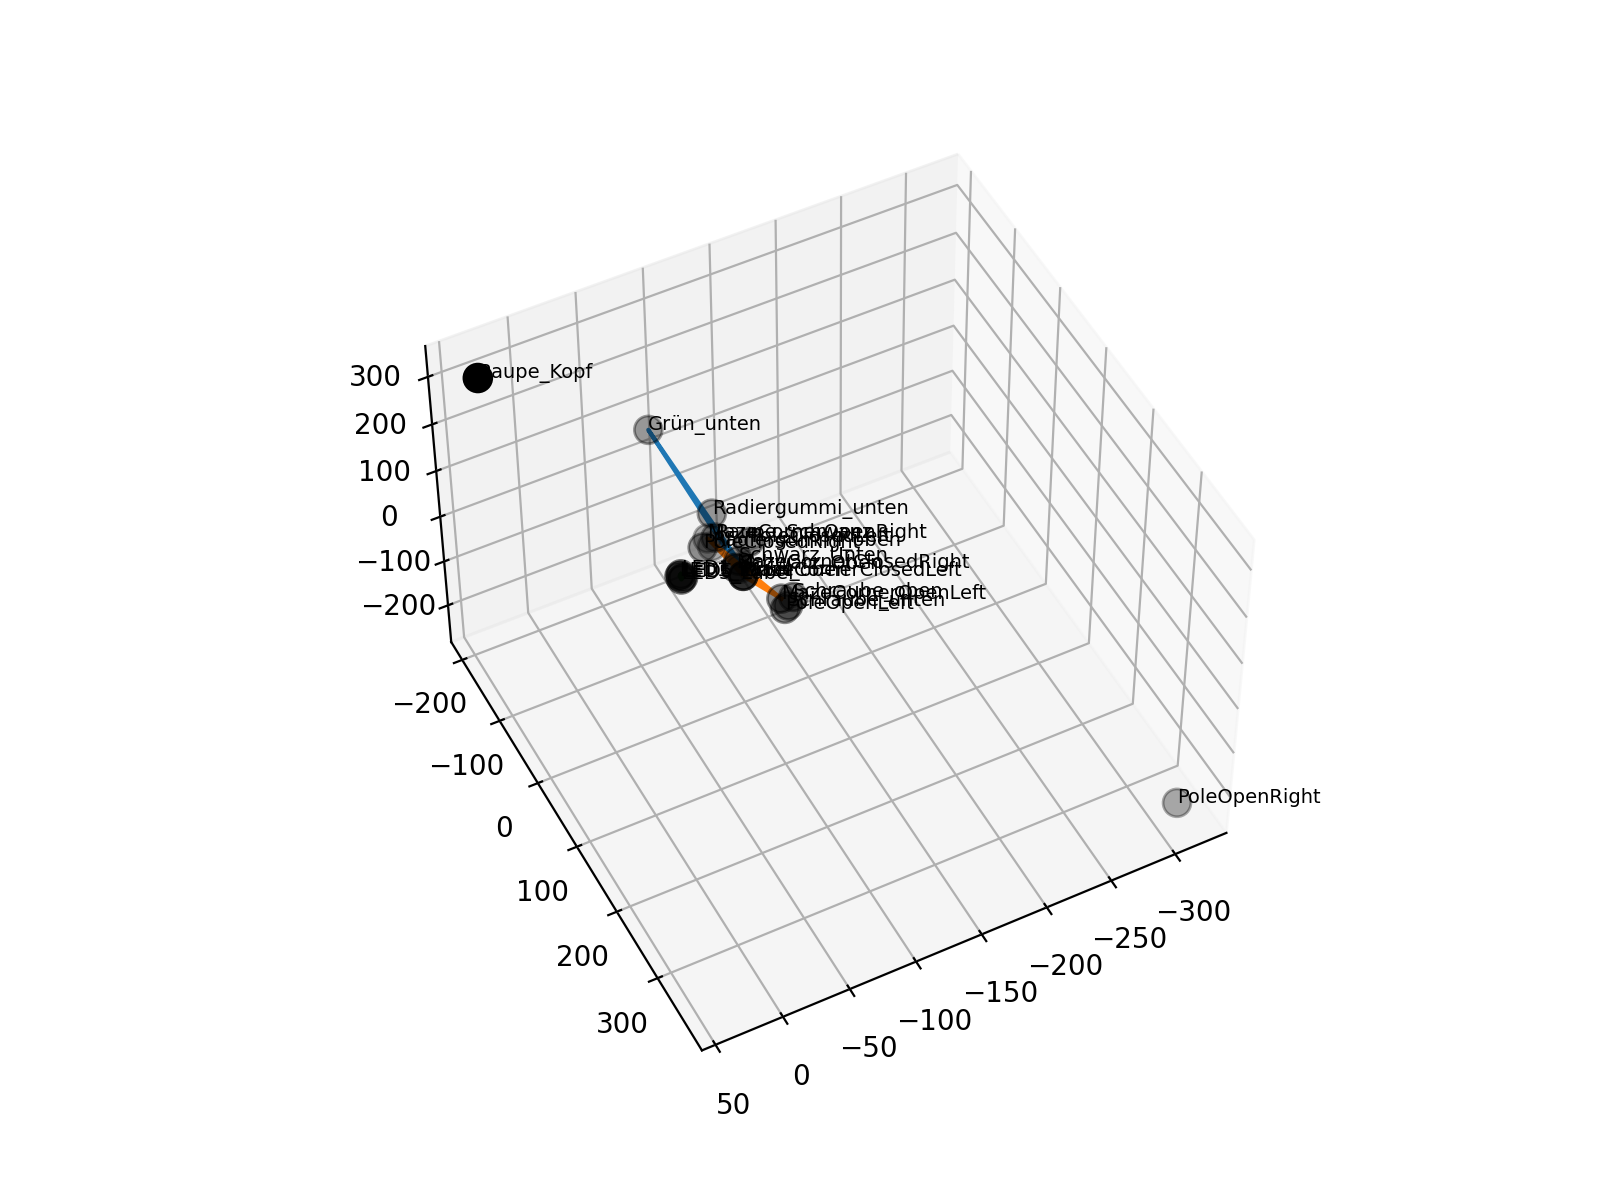

In [148]:
plot_frames_3d(0, p3ds, bodyparts)

## Create a three-dimensional df
#### check the coordinates
#### print mean errors for all keys
#### Compare the triangulated results with the expected ones

In [147]:
df = df_xyz(points, scores, p3ds_flat, reprojerr_flat, bodyparts, reprojerr)
for key in df.iloc[0].keys():
    if "error" in key:
        print(key, df[key].iloc[0])

PoleClosedRight_error 26642.773354486417
PoleClosedLeft_error 0.14189271501626222
PoleOpenRight_error 32.58483778767428
PoleOpenLeft_error 99.84025796218936
MazeCornerClosedRight_error 22687.50671790434
MazeCornerClosedLeft_error 13671.810373507078
MazeCornerOpenLeft_error 35334.30114430875
MazeCornerOpenRight_error 2210.774574202174
Schraube_oben_error 36028.718369524344
Schraube_unten_error 33921.61112375826
Grün_oben_error 28385.920063790243
Grün_unten_error 21655.52403067079
Radiergummi_oben_error 2157.8955716782425
Radiergummi_unten_error 16016.63841468145
Raupe_Kopf_error 3259015.6592804394
Raupe_Schwanz_error 17275.65106065043
Schwarz_Oben_error 12990.688454596348
Schwarz_Unten_error 32933.6030332891
LED1_Label_error 3360.694058880108
LED1_error 3992.4881706131628
LED5_error 3929.8483570856847
LED5_Label_error 3300.109690084184


/var/folders/hx/_gs381js7bx3d219r2yjsf8c0000gn/T/ipykernel_53589/2520672150.py:149: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dout[bp + '_' + axis] = all_points_3d_adj[:, bp_num, ax_num]
/var/folders/hx/_gs381js7bx3d219r2yjsf8c0000gn/T/ipykernel_53589/2520672150.py:149: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dout[bp + '_' + axis] = all_points_3d_adj[:, bp_num, ax_num]
/var/folders/hx/_gs381js7bx3d219r2yjsf8c0000gn/T/ipykernel_53589/2520672150.py:149: PerformanceWarning: DataFrame is highly fragmented.  This is usually

In [86]:
def get_pixel_length_in_cm():
    distance = get_distance_3d("MazeCornerOpenLeft", "MazeCornerClosedLeft")
    factor = distance/50
    return factor

def get_distance_3d(A, B):
    distance = np.sqrt((df[A + "_x"]-df[B + "_x"])**2 + (df[A + "_y"]-df[B + "_y"])**2 + (df[A + "_z"]-df[B + "_z"])**2)
    return distance

def get_distance_in_cm(A, B):
    return get_distance_3d(A, B) / get_pixel_length_in_cm()

In [105]:
get_distance_in_cm("Raupe_Schwanz", "Raupe_Kopf") # expected: 11

0    11.454616
dtype: float64

In [150]:
df

,PoleClosedRight_x,PoleClosedRight_y,PoleClosedRight_z,PoleClosedRight_error,PoleClosedRight_score,PoleClosedLeft_x,PoleClosedLeft_y,PoleClosedLeft_z,PoleClosedLeft_error,PoleClosedLeft_score,...,M_10,M_11,M_12,M_20,M_21,M_22,center_0,center_1,center_2,fnum
0,-82.696948,-40.641629,28.879338,26642.773354,0.999,-110.940305,-18.18637,40.10251,0.141893,0.999,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


### Create a fake-DLC-h5
#### First, select a video, second, find coordinates of the markers (bodyparts) in the video and append them to the dictionary. Next, convert it to a df  with DLC Multiindex and export it to h5

In [119]:
bodyparts = ['PoleClosedRight',
 'PoleClosedLeft',
 'PoleOpenRight',
 'PoleOpenLeft',
 'MazeCornerClosedRight',
 'MazeCornerClosedLeft',
 'MazeCornerOpenLeft',
 'MazeCornerOpenRight',
 'Schraube_oben',
 'Schraube_unten',
 'Grün_oben',
 'Grün_unten',
 'Radiergummi_oben',
 'Radiergummi_unten',
 'Raupe_Kopf',
 'Raupe_Schwanz',
 'Schwarz_Oben',
 'Schwarz_Unten',
 'LED1_Label',
 'LED1',
 'LED5',
 'LED5_Label']
bodyparts

['PoleClosedRight',
 'PoleClosedLeft',
 'PoleOpenRight',
 'PoleOpenLeft',
 'MazeCornerClosedRight',
 'MazeCornerClosedLeft',
 'MazeCornerOpenLeft',
 'MazeCornerOpenRight',
 'Schraube_oben',
 'Schraube_unten',
 'Grün_oben',
 'Grün_unten',
 'Radiergummi_oben',
 'Radiergummi_unten',
 'Raupe_Kopf',
 'Raupe_Schwanz',
 'Schwarz_Oben',
 'Schwarz_Unten',
 'LED1_Label',
 'LED1',
 'LED5',
 'LED5_Label']

<IPython.core.display.Javascript object>


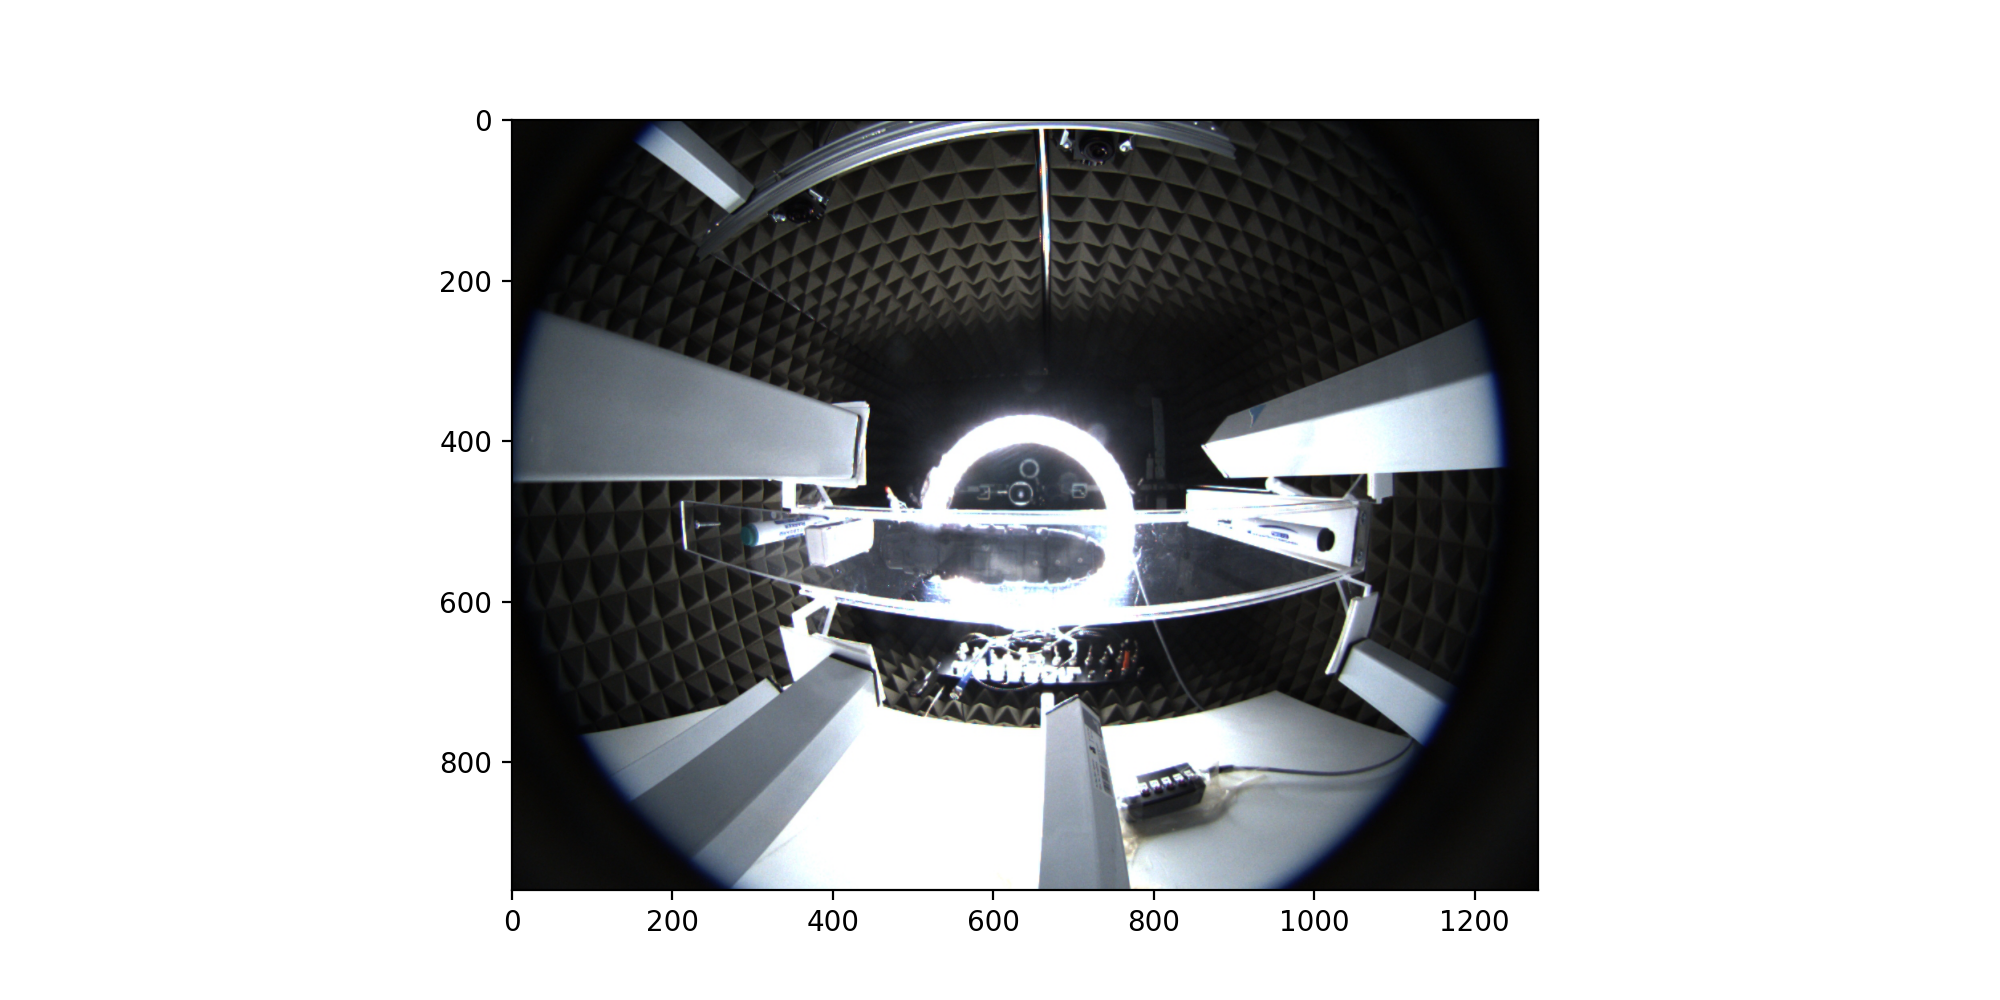

In [118]:
show_video("bottom_positions_nocrop.jpg", 0)

In [140]:
bot_dict = append_marker(737, 538, "Raupe_Schwanz", 0.9999, bot_dict)

19

In [120]:
bot_dict = {}
top_dict = {}
side1_dict = {}
side2_dict = {}

def append_marker(x, y, marker_name, likelihood, dictionary):
    col_dictionary = {"x": [x], "y": [y], "likelihood": [likelihood]}
    dictionary[marker_name] = col_dictionary
    return dictionary

In [142]:
def get_df(dictionary):
    column_names = [[], [], []]
    for key in dictionary.keys():
        for col in ("x", "y", "likelihood"):
            column_names[0].append("PerfectNetwork")
            column_names[1].append(key)
            column_names[2].append(col)
            
    multi_cols = pd.MultiIndex.from_arrays(column_names, names=('scorer', 'bodyparts', 'coords'))
    
    df = pd.DataFrame(data = [], columns = multi_cols)
    
    for key in df.keys():
         for col in ("x", "y", "likelihood"):
            if col in key:
                df[key] = dictionary[key[1]][col]
   
    return df

In [ ]:
n = 0
for dic in (bot_dict, top_dict, side1_dict, side2_dict):
    if n == 0:
        dictname = "bottom"
    if n == 1:
        dictname = "top"
    if n == 2:
        dictname = "side1"
    if n == 3:
        dictname = "side2"

    df = get_df(dic)
    h5_filename =  dictname + ".h5"
    df.to_hdf(h5_filename, "df")
    n += 1

In [143]:
df = get_df(bot_dict)
h5_filename =  ".h5"
df.to_hdf(h5_filename, "df")


In [144]:
pd.read_hdf(".h5")

scorer    PerfectNetwork                                                       \
bodyparts     LED5_Label                 LED1_Label                 LED1        
coords                 x    y likelihood          x    y likelihood    x    y   
0                    827  817     0.9999        769  832     0.9999  774  845   

scorer                     ...                                          \
bodyparts            LED5  ... Radiergummi_oben Radiergummi_unten        
coords    likelihood    x  ...       likelihood                 x    y   
0             0.9999  837  ...           0.9999               375  511   

scorer                                                                         
bodyparts            Raupe_Kopf                 Raupe_Schwanz                  
coords    likelihood          x    y likelihood             x    y likelihood  
0             0.9999        460  541     0.9999           737  538     0.9999  

[1 rows x 57 columns]

### Some lines of code if we have to modify something in the h5 file

In [61]:
filename = "top_crop.h5"
df = pd.read_hdf(filename)
df

MultiIndex([('PerfectNetwork',                  'LED5',          'x'),
            ('PerfectNetwork',                  'LED5',          'y'),
            ('PerfectNetwork',                  'LED5', 'likelihood'),
            ('PerfectNetwork',            'LED5_Label',          'x'),
            ('PerfectNetwork',            'LED5_Label',          'y'),
            ('PerfectNetwork',            'LED5_Label', 'likelihood'),
            ('PerfectNetwork',                  'LED1',          'x'),
            ('PerfectNetwork',                  'LED1',          'y'),
            ('PerfectNetwork',                  'LED1', 'likelihood'),
            ('PerfectNetwork',            'LED1_Label',          'x'),
            ('PerfectNetwork',            'LED1_Label',          'y'),
            ('PerfectNetwork',            'LED1_Label', 'likelihood'),
            ('PerfectNetwork',         'Schwarz_unten',          'x'),
            ('PerfectNetwork',         'Schwarz_unten',          'y'),
      

In [45]:
df[('PerfectNetwork', 'PoleClosedLeft', 'x')] = 282
df[('PerfectNetwork', 'PoleClosedLeft', 'x')]

0    282
Name: (PerfectNetwork, PoleClosedLeft, x), dtype: int64

In [62]:
new_column_names = []
for column_tuple in df.columns:
    if "Schwarz" in column_tuple[1]:
        a, c = column_tuple[0], column_tuple[2]
        if "oben" in column_tuple[1]:
            b = 'Schwarz_Oben'
        elif "unten" in column_tuple[1]:
            b = 'Schwarz_Unten'
        else:
            b = column_tuple[1]
        new_column_names.append((a, b, c))
    else:
        new_column_names.append(column_tuple)
df.columns = pd.MultiIndex.from_tuples(new_column_names, names=('scorer', 'bodyparts', 'coords'))
df.columns

MultiIndex([('PerfectNetwork',                  'LED5',          'x'),
            ('PerfectNetwork',                  'LED5',          'y'),
            ('PerfectNetwork',                  'LED5', 'likelihood'),
            ('PerfectNetwork',            'LED5_Label',          'x'),
            ('PerfectNetwork',            'LED5_Label',          'y'),
            ('PerfectNetwork',            'LED5_Label', 'likelihood'),
            ('PerfectNetwork',                  'LED1',          'x'),
            ('PerfectNetwork',                  'LED1',          'y'),
            ('PerfectNetwork',                  'LED1', 'likelihood'),
            ('PerfectNetwork',            'LED1_Label',          'x'),
            ('PerfectNetwork',            'LED1_Label',          'y'),
            ('PerfectNetwork',            'LED1_Label', 'likelihood'),
            ('PerfectNetwork',         'Schwarz_Unten',          'x'),
            ('PerfectNetwork',         'Schwarz_Unten',          'y'),
      

In [63]:
df.to_hdf(filename, "df")